In [1]:
# IMPORTS

import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from datetime import datetime, timedelta

### SPECTRA PLOTS

In [18]:
# location of spectra files generated by zonal_energy_spectrum.ipynb
aifs_path = "/scratch/dx2/cl6824/Fourier/AIFS"
e5_path = "/scratch/dx2/cl6824/Fourier/ERA5"
ifs_path = "/scratch/dx2/cl6824/Fourier/IFS"
ifs_fc_path = "/scratch/dx2/cl6824/Fourier/IFS_FC"
aifs_ens_path = "/scratch/dx2/cl6824/Fourier/AIFS_ens"
barra2_path = "/scratch/dx2/cl6824/Fourier/BARRA2"

In [19]:
def def_rossby(lat: float) -> float:
    """
    DEPRECATED : not needed anymore, and altitude should be a parameter

    
    Calculates the Rossby deformation wavenumber at a given latitude.

    The Rossby deformation wavenumber (k_D) is the inverse of the Rossby
    deformation radius (L_D), which characterizes the scale at which
    rotational effects (Coriolis force) and buoyancy effects (stratification)
    are in balance in the atmosphere or ocean.

    Args:
        lat (float): Latitude in degrees.

    Returns:
        float: Rossby deformation wavenumber (non-dimensional).
    """

    # Physical constants
    Omega = 7.2921e-5   # Earth's rotation rate [rad/s]
    g = 9.81            # Gravitational acceleration [m/s²]
    H = 10000           # Characteristic scale height [m] (10 km typical for troposphere)
    N = 0.01            # Brunt–Väisälä frequency [s⁻¹], typical value in troposphere
                        # (true formula: N = (g/θ) * (dθ/dz))

    # Convert latitude to radians
    lat_rad = np.deg2rad(lat)
    # Coriolis parameter at latitude φ
    f = abs(2 * Omega * np.sin(lat_rad))  # [s⁻¹]
    # Rossby deformation radius [m]
    L_D = (N * H) / f
    # Earth's mean radius [m]
    R = 6.37e6
    # Rossby deformation wavenumber (dimensionless, scaled by Earth's radius)
    ross = R / L_D
    return ross

def scaled_power_law(k, base_k, base_E, slope):
    """Return E(k) ∝ (k/base_k)^slope scaled to base_E.
    base_k and base_E define a reference point
    k can be a numpy array of wavenumbers, or a single wavenumber
    slope represents the logarythmic slope of the curve (-3 at low wavenumbers, -5/3 at high wavenumbers)
    """
    return base_E * (k/base_k) ** slope

#### GLOBE

In [20]:
# level selection between 200 and 500 (hPa)
level = 500

In [21]:
# listing files to retrieve
files_aifs = sorted([el for el in os.listdir(os.path.join(aifs_path, f"wind_speed_{level}hPa")) if el.endswith(".nc")])
files_aifs = [os.path.join(aifs_path, f"wind_speed_{level}hPa", efile) for efile in files_aifs]
files_e5 = sorted([el for el in os.listdir(os.path.join(e5_path, f"wind_speed_{level}hPa")) if el.endswith(".nc")])
files_e5 = [os.path.join(e5_path, f"wind_speed_{level}hPa", efile) for efile in files_e5]
files_ifs = sorted([el for el in os.listdir(os.path.join(ifs_path, f"wind_speed_{level}hPa")) if el.endswith(".nc")])
files_ifs = [os.path.join(ifs_path, f"wind_speed_{level}hPa", efile) for efile in files_ifs]
files_ifs_fc = sorted([el for el in os.listdir(os.path.join(ifs_fc_path, f"wind_speed_{level}hPa")) if el.endswith(".nc")])
files_ifs_fc = [os.path.join(ifs_fc_path, f"wind_speed_{level}hPa", efile) for efile in files_ifs_fc]
files_aifs_ens = sorted([el for el in os.listdir(os.path.join(aifs_ens_path, f"wind_speed_{level}hPa")) if el.endswith(".nc")])
files_aifs_ens = [os.path.join(aifs_ens_path, f"wind_speed_{level}hPa", efile) for efile in files_aifs_ens]

In [23]:
# listing lead times
#lead_times = [(i+1)*6 for i in range(len(files_aifs))] # +360h (AIFS max range)
lead_times = [(i+1)*6 for i in range(len(files_ifs_fc))] # +240h (IFS max range)

In [24]:
# pre-loading both era5 and IFS analysis as they do not depend on lead time
e5 = xr.open_dataset(files_e5[0])
ifs = xr.open_dataset(files_ifs[0]).sortby("latitude", ascending=False)

In [25]:
# defines a list of latitude ranges for which plots will be made
# !!! I changed the code since the files where made.
# The latitudes are now sorted so the slices starts and ends should be in ascending order
ranges = [slice(i+30, i) for i in range(-90, -29, 30)] + [slice(15, -15)]

In [26]:
for i, lead_time in enumerate(tqdm(lead_times, desc="Lead times")):
    for erange in tqdm(ranges, desc=f"Lat ranges @ +{lead_time:03d}h", leave=False):

        # load AIFS file
        file = files_aifs[i] # using i as files are sorted by lead time
        ds = xr.open_dataset(file)

        # load AIFS ens file
        file = files_aifs_ens[i] # using i as files are sorted by lead time
        aifs_ens = xr.open_dataset(file)

        # load IFS_fc files
        file = files_ifs_fc[i] # using i as files are sorted by lead time
        ifs_fc = xr.open_dataset(file, decode_timedelta=True).isel(step=0)
        ifs_fc = ifs_fc.drop_vars(["number", "step"]) # no time to redo it in the code that makes the files, cf IFS forecast file save, but why is isel(step=0) still required? necessary but don't understand

        # select the given range of latitudes
        ds_lat = ds.sel(latitude=erange)
        e5_lat = e5.sel(latitude=erange)
        ifs_lat = ifs.sel(latitude=erange)
        ifs_fc_lat = ifs_fc.sel(latitude=erange)
        aifs_ens_lat = aifs_ens.sel(latitude=erange)

        # perform a weighted mean on latitudes
        weights = np.cos(np.deg2rad(e5_lat["latitude"]))
        weights.name = "weights"

        ds_lat = ds_lat.weighted(weights).mean(dim="latitude")
        e5_lat = e5_lat.weighted(weights).mean(dim="latitude")
        ifs_lat = ifs_lat.weighted(weights).mean(dim="latitude")
        ifs_fc_lat = ifs_fc_lat.weighted(weights).mean(dim="latitude")
        aifs_ens_lat = aifs_ens_lat.weighted(weights).mean(dim="latitude")

        # select spectral density for each model
        energy = ds_lat.__xarray_dataarray_variable__
        e5_energy = e5_lat.__xarray_dataarray_variable__
        ifs_energy = ifs_lat.__xarray_dataarray_variable__
        ifs_fc_energy = ifs_fc_lat.__xarray_dataarray_variable__
        aifs_ens_energy = aifs_ens_lat.__xarray_dataarray_variable__

        # select wavenumbers (they are probably the same)
        wn = ds_lat.zonal_wavenumber
        e5_wn = e5_lat.zonal_wavenumber
        ifs_wn = ifs_lat.zonal_wavenumber
        ifs_fc_wn = ifs_fc_lat.zonal_wavenumber
        aifs_ens_wn = aifs_ens_lat.zonal_wavenumber

        plt.figure(figsize=(6, 4))  # Create the figure once, outside the loop
        # theory curves
        theo_five_third = scaled_power_law(wn[400:], 400, 5e7, -5/3)
        theo_three = scaled_power_law(wn[1:], 100, 1e10, -3)
        plt.loglog(wn[400:], theo_five_third, linewidth=1, color="black", linestyle=':', label=f'high frequency scaled power law (-5/3)')
        plt.loglog(wn[1:], theo_three, linewidth=1, color="black", label=f'low frequency scaled power law (-3)')

        # plot spectral densities
        plt.loglog(wn[1:], energy[1:], linewidth=2, label=f'AIFS +{lead_time:03d}h')
        plt.loglog(aifs_ens_wn[1:], aifs_ens_energy[1:], label=f'AIFS ENS central member +{lead_time:03d}h', linewidth=2)
        plt.loglog(ifs_wn[1:], ifs_energy[1:], label=f'IFS analysis', linewidth=2)
        plt.loglog(ifs_fc_wn[1:], ifs_fc_energy[1:], label=f'IFS forecast +{lead_time:03d}h', linewidth=2)
        plt.loglog(e5_wn[1:], e5_energy[1:], label=f'ERA5', linewidth=2)

        # Axis scale
        ax = plt.gca()
        ax.set_xscale('log')
        ax.set_xlim(left=1)
        ax.set_yscale('log')
        ax.set_ylim(1, 5e13)

        # Finding unresolved scales
        # dx = 0.25 * (np.pi/180) * 6371e3 * np.cos(np.deg2rad(lat))
        # lambda_min = mult * dx # (mult must be at least 2 (2*dx limit))
        # circumference = 2 * np.pi * 6371e3 * np.cos(np.deg2rad(lat))
        # m_max = circumference / lambda_min
        mult = 4
        m_max = 360 / (mult * 0.25)
        ax.axvspan(m_max, ax.get_xlim()[1], color='red', alpha=0.1,
                   label=f'Non-resolved scales (< {mult}*dx)')

        # plot rossby deformation wavenumber
        # x = (erange.start + erange.stop) / 2 # mean latitude of current range
        # def_ross = def_rossby(x)
        # ax.axvline(x=def_ross, linestyle='--', linewidth=1.5, label=f'Rossby deformation wavenumber at {int(x)}°')

        # Gridlines on all ticks
        ax.grid(True, which='both')

        # Labels and legend
        plt.xlabel('Zonal wavenumber', fontsize=12)
        plt.ylabel('Power spectral density', fontsize=12)
        lat_txt = f"{int(erange.start):+03d}° to {int(erange.stop):+03d}°"
        plt.title(f'Zonal Energy Spectrums at {level}hPa (+{lead_time:03d}h) from {lat_txt}', fontsize=13)
        plt.legend(fontsize=8,labelspacing=0.3, loc='lower left')
        plt.tight_layout()

        # save
        os.makedirs(f"/scratch/dx2/cl6824/plots/lat_lead_spectra/{lead_time:03d}", exist_ok=True)
        plt.savefig(f"/scratch/dx2/cl6824/plots/lat_lead_spectra/{lead_time:03d}/range_{int(erange.start):+03d}_{int(erange.stop):+03d}_{level}hPa.png")
        plt.close()
        #plt.show()

Lead times:   0%|          | 0/40 [00:00<?, ?it/s]

Lat ranges @ +006h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +012h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +018h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +024h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +030h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +036h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +042h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +048h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +054h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +060h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +066h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +072h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +078h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +084h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +090h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +096h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +102h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +108h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +114h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +120h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +126h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +132h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +138h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +144h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +150h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +156h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +162h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +168h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +174h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +180h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +186h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +192h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +198h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +204h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +210h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +216h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +222h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +228h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +234h:   0%|          | 0/4 [00:00<?, ?it/s]

Lat ranges @ +240h:   0%|          | 0/4 [00:00<?, ?it/s]

In [29]:
# evolution with lead time
import glob
import imageio.v3 as iio   # ImageIO v3 API

for erange in tqdm(ranges):
    lead_times = [efile for efile in sorted(os.listdir("/scratch/dx2/cl6824/plots/lat_lead_spectra")) if not efile.startswith((".", "_", "regional"))]
    files = [os.path.join("/scratch/dx2/cl6824/plots/lat_lead_spectra", lead_time, f"range_{int(erange.start):+03d}_{int(erange.stop):+03d}_{level}hPa.png") for lead_time in lead_times]
    # Read them into memory
    frames = [iio.imread(f) for f in files]

    # Write the GIF
    # duration = seconds per frame  (0.1 s = 10 fps)
    # loop=0 means loop forever; use loop=1 for no looping
    iio.imwrite(f"/scratch/dx2/cl6824/plots/lat_lead_spectra/_gifs/lat/AIFS_zonal_energy_spectrum_anim_lats_{int(erange.start):+03d}_{int(erange.stop):+03d}_{level}hPa.gif", frames, duration=0.3, loop=0)


  0%|          | 0/4 [00:00<?, ?it/s]

#### BARRA2 domain

In [4]:
# level selection between 200 and 500 (hPa)
level = 500

In [5]:
# listing files to retrieve
files_aifs = sorted([el for el in os.listdir(os.path.join(aifs_path, "area")) if el.endswith(".nc")])
files_aifs = [os.path.join(aifs_path, "area", efile) for efile in files_aifs]
files_e5 = sorted([el for el in os.listdir(os.path.join(e5_path, "area")) if el.endswith(".nc")])
files_e5 = [os.path.join(e5_path, "area", efile) for efile in files_e5]
files_ifs = sorted([el for el in os.listdir(os.path.join(ifs_path, "area")) if el.endswith(".nc")])
files_ifs = [os.path.join(ifs_path, "area", efile) for efile in files_ifs]
files_ifs_fc = sorted([el for el in os.listdir(os.path.join(ifs_fc_path, "area")) if el.endswith(".nc")])
files_ifs_fc = [os.path.join(ifs_fc_path, "area", efile) for efile in files_ifs_fc]
files_aifs_ens = sorted([el for el in os.listdir(os.path.join(aifs_ens_path, "area")) if el.endswith(".nc")])
files_aifs_ens = [os.path.join(aifs_ens_path, "area", efile) for efile in files_aifs_ens]
files_barra2 = sorted([el for el in os.listdir(os.path.join(barra2_path, "area")) if el.endswith(".nc")])
files_barra2 = [os.path.join(barra2_path, "area", efile) for efile in files_barra2]

In [6]:
# listing lead times
#lead_times = [(i+1)*6 for i in range(len(files_aifs))] # +360h (AIFS max range)
lead_times = [(i+1)*6 for i in range(len(files_ifs_fc))] # +240h (IFS max range)

In [9]:
# pre-loading both era5, IFS and BARRA2 as they do not depend on lead time
e5 = xr.open_dataset(files_e5[0])
ifs = xr.open_dataset(files_ifs[0])
barra2 = xr.open_dataset(files_barra2[0])

In [10]:
# defines a list of latitude ranges for which plots will be made
# latitude min in BARRA2 AUS-22 domain = -56.49°
# latitude max in BARRA2 AUS-22 domain = 11.71°
ranges = [slice(-40, -10)]


In [15]:
for i, lead_time in enumerate(tqdm(lead_times, desc="Lead times")):
    for erange in tqdm(ranges, desc=f"Lat ranges @ +{lead_time:03d}h", leave=False):

        # load AIFS file
        file = files_aifs[i] # using i as files are sorted by lead time
        ds = xr.open_dataset(file)

        # load AIFS ens file
        file = files_aifs_ens[i] # using i as files are sorted by lead time
        aifs_ens = xr.open_dataset(file)

        # load IFS_fc files
        file = files_ifs_fc[i] # using i as files are sorted by lead time
        ifs_fc = xr.open_dataset(file).isel(step=0)
        ifs_fc = ifs_fc.drop_vars(["number"]) # no time to redo it in the code that makes the files, cf IFS forecast file save, but why is isel(step=0) still required? necessary but don't understand

        # select the given range of latitudes
        ds_lat = ds.sel(latitude=erange)
        e5_lat = e5.sel(latitude=erange)
        ifs_lat = ifs.sel(latitude=erange)
        ifs_fc_lat = ifs_fc.sel(latitude=erange)
        aifs_ens_lat = aifs_ens.sel(latitude=erange)
        b2_lat = barra2.sel(latitude=erange)

        # perform a weighted mean on latitudes
        # .25° lat weights
        weights = np.cos(np.deg2rad(e5_lat["latitude"]))
        weights.name = "weights"
        # barra2 weights
        b2_weights = np.cos(np.deg2rad(b2_lat["latitude"]))
        b2_weights.name = "weights"

        ds_lat = ds_lat.weighted(weights).mean(dim="latitude")
        e5_lat = e5_lat.weighted(weights).mean(dim="latitude")
        ifs_lat = ifs_lat.weighted(weights).mean(dim="latitude")
        ifs_fc_lat = ifs_fc_lat.weighted(weights).mean(dim="latitude")
        aifs_ens_lat = aifs_ens_lat.weighted(weights).mean(dim="latitude")
        b2_lat = b2_lat.weighted(b2_weights).mean(dim="latitude")

        # select spectral density for each model
        energy = ds_lat.__xarray_dataarray_variable__
        e5_energy = e5_lat.__xarray_dataarray_variable__
        ifs_energy = ifs_lat.__xarray_dataarray_variable__
        ifs_fc_energy = ifs_fc_lat.__xarray_dataarray_variable__
        aifs_ens_energy = aifs_ens_lat.__xarray_dataarray_variable__
        b2_energy = b2_lat.__xarray_dataarray_variable__

        # select wavenumbers (they are probably the same)
        wn = ds_lat.zonal_wavenumber
        e5_wn = e5_lat.zonal_wavenumber
        ifs_wn = ifs_lat.zonal_wavenumber
        ifs_fc_wn = ifs_fc_lat.zonal_wavenumber
        aifs_ens_wn = aifs_ens_lat.zonal_wavenumber
        b2_wn = b2_lat.zonal_wavenumber

        plt.figure(figsize=(6, 4))  # Create the figure once, outside the loop
        # theory curves
        theo_five_third = scaled_power_law(wn[400:], 400, 5e7, -5/3)
        theo_three = scaled_power_law(wn[1:], 100, 1e10, -3)
        plt.loglog(wn[400:], theo_five_third, linewidth=1, color="black", linestyle=':', label=f'high frequency scaled power law (-5/3)')
        plt.loglog(wn[1:], theo_three, linewidth=1, color="black", label=f'low frequency scaled power law (-3)')

        # plot spectral densities
        plt.loglog(wn[1:], energy[1:], linewidth=2, label=f'AIFS +{lead_time:03d}h')
        plt.loglog(aifs_ens_wn[1:], aifs_ens_energy[1:], label=f'AIFS ENS central member +{lead_time:03d}h', linewidth=2)
        plt.loglog(ifs_wn[1:], ifs_energy[1:], label=f'IFS analysis', linewidth=2)
        plt.loglog(ifs_fc_wn[1:], ifs_fc_energy[1:], label=f'IFS forecast +{lead_time:03d}h', linewidth=2)
        plt.loglog(e5_wn[1:], e5_energy[1:], label=f'ERA5', linewidth=2)
        plt.loglog(b2_wn[1:], b2_energy[1:], label=f'BARRA2', linewidth=2)

        # Axis scale
        ax = plt.gca()
        ax.set_xscale('log')
        ax.set_xlim(left=1)
        ax.set_yscale('log')
        ax.set_ylim(1, 5e13)

        # Finding unresolved scales
        # dx = 0.25 * (np.pi/180) * 6371e3 * np.cos(np.deg2rad(lat))
        # lambda_min = mult * dx # (mult must be at least 2 (2*dx limit))
        # circumference = 2 * np.pi * 6371e3 * np.cos(np.deg2rad(lat))
        # m_max = circumference / lambda_min
        mult = 4
        m_max = 360 / (mult * 0.25)
        ax.axvspan(m_max, ax.get_xlim()[1], color='red', alpha=0.1,
                   label=f'Non-resolved scales (< {mult}*dx)')

        # plot rossby deformation wavenumber
        # x = (erange.start + erange.stop) / 2 # mean latitude of current range
        # def_ross = def_rossby(x)
        # ax.axvline(x=def_ross, linestyle='--', linewidth=1.5, label=f'Rossby deformation wavenumber at {int(x)}°')

        # Gridlines on all ticks
        ax.grid(True, which='both')

        # Labels and legend
        plt.xlabel('Zonal wavenumber', fontsize=12)
        plt.ylabel('Power spectral density', fontsize=12)
        lat_txt = f"{int(erange.start):+03d}° to {int(erange.stop):+03d}°"
        plt.title(f'Regional Energy Spectrums at {level}hPa (+{lead_time:03d}h) from {lat_txt}', fontsize=13)
        plt.legend(fontsize=8,labelspacing=0.3, loc='lower left')
        plt.tight_layout()

        # save
        os.makedirs(f"/scratch/dx2/cl6824/plots/lat_lead_spectra/regional/{lead_time:03d}", exist_ok=True)
        plt.savefig(f"/scratch/dx2/cl6824/plots/lat_lead_spectra/regional/{lead_time:03d}/range_{int(erange.start):+03d}_{int(erange.stop):+03d}_{level}hPa.png")
        plt.close()
        #plt.show()

Lead times:   0%|          | 0/40 [00:00<?, ?it/s]

Lat ranges @ +006h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +012h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +018h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +024h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +030h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +036h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +042h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +048h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +054h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +060h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +066h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +072h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +078h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +084h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +090h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +096h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +102h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +108h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +114h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +120h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +126h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +132h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +138h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +144h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +150h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +156h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +162h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +168h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +174h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +180h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +186h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +192h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +198h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +204h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +210h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +216h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +222h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +228h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +234h:   0%|          | 0/1 [00:00<?, ?it/s]

Lat ranges @ +240h:   0%|          | 0/1 [00:00<?, ?it/s]

In [17]:
# evolution with lead time
import glob
import imageio.v3 as iio   # ImageIO v3 API

for erange in tqdm(ranges):
    lead_times = [efile for efile in sorted(os.listdir("/scratch/dx2/cl6824/plots/lat_lead_spectra/regional")) if not efile.startswith((".", "_"))]
    files = [os.path.join("/scratch/dx2/cl6824/plots/lat_lead_spectra/regional", lead_time, f"range_{int(erange.start):+03d}_{int(erange.stop):+03d}_{level}hPa.png") for lead_time in lead_times]
    # Read them into memory
    frames = [iio.imread(f) for f in files]

    # Write the GIF
    # duration = seconds per frame  (0.1 s = 10 fps)
    # loop=0 means loop forever; use loop=1 for no looping
    iio.imwrite(f"/scratch/dx2/cl6824/plots/lat_lead_spectra/regional/_gifs/lat/AIFS_zonal_energy_spectrum_anim_lats_{int(erange.start):+03d}_{int(erange.stop):+03d}_{level}hPa.gif", frames, duration=0.3, loop=0)


  0%|          | 0/1 [00:00<?, ?it/s]

### IFS DOWNLOAD

In [ ]:
#!/usr/bin/env python3
# coding: utf-8

import os
from ecmwf.opendata import Client
from ecmwfapi import ECMWFService


def ifs_an_request_aifs(date):
    t_dict = dict(
        date=date,
    )
    # Base dict has to be this format because using 'class' as a kwarg causes a syntax error
    # base_dict = {
    #     'class': 'od', 'domain': 'g',
    #     'expver': '0001', 'step': 0,
    #     'stream': 'oper', 'type': 'an',
    #     'grid': 'N320', 'area': '90/0.0/-90/360',
    # }
    # analysis
    base_dict = {
        'class': 'od', 'domain': 'g',
        'expver': '0001', 'step': 0,
        'stream': 'oper', 'type': 'an',
        'grid': '0.25/0.25', 'area': '90/0.0/-90/360',
    }
    #forecast
    base_dict = {
        'class': 'od', 'domain': 'g',
        'expver': '0001', 'step': "6/to/240/by/6",
        'stream': 'oper', 'type': 'fc',
        'grid': '0.25/0.25', 'area': '90/0.0/-90/360',
    }
    #sfc_request = dict(
    #    levtype='sfc',
    #    param='10u/10v/2d/2t/lsm/msl/sdor/skt/slor/sp/tcw/z', 
    #)
    pl_request = dict(
        levtype='pl',
        levelist="200/500",
        param="u/v/w",
    )
    #sl_request = dict(
    #    levtype='sfc',
    #    param="stl1/stl2/swvl1/swvl2",
    #)

    requests = {
        #'sfc_request': {**sfc_request, **t_dict, **base_dict},
        'pl_request': {**pl_request, **t_dict, **base_dict},
        #'sl_request': {**sl_request, **t_dict, **base_dict},
    }
    for r in requests:
        requests[r] = ['{}={}'.format(k, v) for k, v in requests[r].items()]
        requests[r] = 'retrieve,\n{}'.format(','.join(requests[r]))
    combined_request = [requests[r] for r in requests]
    combined_request = '\n\n'.join(combined_request)

    return combined_request

# durations = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31] # number of days per month
# for month in range(1, 12):
    
dates = [(datetime.strptime('20240101', '%Y%m%d') + timedelta(days=x*3)).strftime('%Y%m%d') for x in range(122)]
months = {}
for month in range(1, 13):
    months[month] = []

for d in dates:
    month = int(d[4:6])
    months[month].append(d)

for month, days in months.items():
    if month != 1:
        print(months[month])
        date = "/".join(days)
        CACHE_DIR='/g/data/dx2/ML/AIFS/resources'
        os.environ['ECMWF_API_RC_FILE'] = os.path.join(CACHE_DIR, 'ecmwfapirc')
        request = ifs_an_request_aifs(date)
        output_file = f"/g/data/dx2/cl6824/ML/IFS_FC/ifs_wind_2024{month:02d}.grib"
        # output_file = f"/g/data/dx2/cl6824/ML/IFS_FC/ifs_wind_2024{month:.02d}.grib"
        server = ECMWFService("mars")
        server.execute(request, output_file)
# for edate in dates:
# # print(dates)
# # date = f"2024-{month:02d}-01/to/2024-{month:02d}-{durations[month-1]}"
# # print(date)
# # This is where the API key for MARS is stored
#     CACHE_DIR='/g/data/dx2/ML/AIFS/resources'
#     os.environ['ECMWF_API_RC_FILE'] = os.path.join(CACHE_DIR, 'ecmwfapirc')

#     request = ifs_an_request_aifs(edate)

#     # output_file = f"/g/data/dx2/cl6824/ML/IFS_FC/ifs_wind_2024_{month:02d}.grib"
#     output_file = f"/g/data/dx2/cl6824/ML/IFS_FC/ifs_wind_{edate}.grib"
#     server = ECMWFService("mars")
#     server.execute(request, output_file)



print('Done.')


['20240203', '20240206', '20240209', '20240212', '20240215', '20240218', '20240221', '20240224', '20240227']
2025-08-22 14:53:32 ECMWF API python library 1.6.5
2025-08-22 14:53:32 ECMWF API at https://api.ecmwf.int/v1
2025-08-22 14:53:34 Welcome Spc BOM
2025-08-22 14:53:37 In case of problems, please check https://confluence.ecmwf.int/display/WEBAPI/Web+API+FAQ or contact servicedesk@ecmwf.int
2025-08-22 14:53:38 Request submitted
2025-08-22 14:53:38 Request id: 68a7f7d20e6c376458679b7d
2025-08-22 14:53:38 Request is submitted


### TESTS

In [36]:
def c(ds):
    print(np.isnan(ds.to_array()).sum().item())

  0%|          | 0/1 [00:00<?, ?it/s]

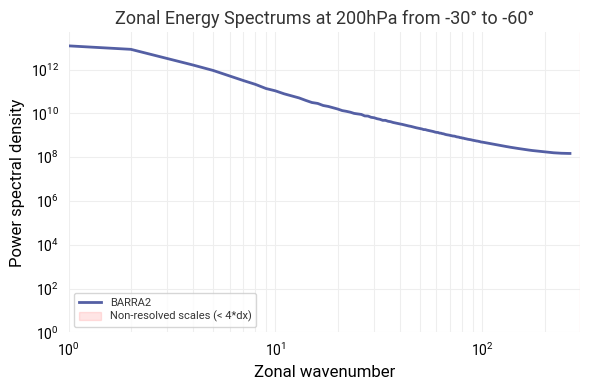

In [45]:
ranges = [slice(-30, -60)]
for erange in tqdm(ranges):

    # select the given range of latitudes
    barra2_lat = barra2.sel(latitude=erange)

    # perform a weighted mean on latitudes
    weights = np.cos(np.deg2rad(barra2_lat["latitude"]))
    weights.name = "weights"

    
    barra2_lat = barra2_lat.weighted(weights).mean(dim="latitude")

    # select spectral density for each model
    
    barra2_energy = barra2_lat.__xarray_dataarray_variable__

    # select wavenumbers (they are probably the same)
    
    barra2_wn = barra2_lat.zonal_wavenumber

    plt.figure(figsize=(6, 4))  # Create the figure once, outside the loop
    # theory curves
    # theo_five_third = scaled_power_law(barra2_wn[400:], 400, 5e7, -5/3)
    # theo_three = scaled_power_law(wn[1:], 100, 1e10, -3)
    # plt.loglog(barra2_wn[400:], theo_five_third, linewidth=1, color="black", linestyle=':', label=f'high frequency scaled power law (-5/3)')
    # plt.loglog(barra2_wn[1:], theo_three, linewidth=1, color="black", label=f'low frequency scaled power law (-3)')

    # plot spectral densities
    # plt.loglog(wn[1:], energy[1:], linewidth=2, label=f'AIFS +{lead_time:03d}h')
    # plt.loglog(aifs_ens_wn[1:], aifs_ens_energy[1:], label=f'AIFS ENS central member +{lead_time:03d}h', linewidth=2)
    # plt.loglog(ifs_wn[1:], ifs_energy[1:], label=f'IFS analysis', linewidth=2)
    # plt.loglog(ifs_fc_wn[1:], ifs_fc_energy[1:], label=f'IFS forecast +{lead_time:03d}h', linewidth=2)
    # plt.loglog(e5_wn[1:], e5_energy[1:], label=f'ERA5', linewidth=2)
    plt.loglog(barra2_wn[1:], barra2_energy[1:], label=f'BARRA2', linewidth=2)

    # Axis scale
    ax = plt.gca()
    ax.set_xscale('log')
    ax.set_xlim(left=1)
    ax.set_yscale('log')
    ax.set_ylim(1, 5e13)

    # Finding unresolved scales
    # dx = 0.25 * (np.pi/180) * 6371e3 * np.cos(np.deg2rad(lat))
    # lambda_min = mult * dx # (mult must be at least 2 (2*dx limit))
    # circumference = 2 * np.pi * 6371e3 * np.cos(np.deg2rad(lat))
    # m_max = circumference / lambda_min
    mult = 4
    m_max = 360 / (mult * 0.25)
    ax.axvspan(m_max, ax.get_xlim()[1], color='red', alpha=0.1,
               label=f'Non-resolved scales (< {mult}*dx)')

    # plot rossby deformation wavenumber
    # x = (erange.start + erange.stop) / 2 # mean latitude of current range
    # def_ross = def_rossby(x)
    # ax.axvline(x=def_ross, linestyle='--', linewidth=1.5, label=f'Rossby deformation wavenumber at {int(x)}°')

    # Gridlines on all ticks
    ax.grid(True, which='both')

    # Labels and legend
    plt.xlabel('Zonal wavenumber', fontsize=12)
    plt.ylabel('Power spectral density', fontsize=12)
    lat_txt = f"{int(erange.start):+03d}° to {int(erange.stop):+03d}°"
    plt.title(f'Zonal Energy Spectrums at {level}hPa from {lat_txt}', fontsize=13)
    plt.legend(fontsize=8,labelspacing=0.3, loc='lower left')
    plt.tight_layout()

    # save
    # os.makedirs(f"/scratch/dx2/cl6824/plots/lat_lead_spectra/{lead_time:03d}", exist_ok=True)
    # plt.savefig(f"/scratch/dx2/cl6824/plots/lat_lead_spectra/{lead_time:03d}/range_{int(erange.start):+03d}_{int(erange.stop):+03d}_{level}hPa.png")
    # plt.close()
    plt.show()